In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize

1. The population of a certain country is modeled with three age groups: minors, adults, and silvers. Each year 5% of the minors grow into adulthood and 2% pass away from childhood diseases. Each year 4% of adults become silvers, 2% pass away, and there is a 3% reproduction rate. Each year 5% of the seniors pass away and there is a 1% reproduction rate.

a) If the population vector is $P = \begin{bmatrix} \text{seniors} \\ \text{adults} \\ \text{minors} \end{bmatrix}$ find the matrix $A$ for which $P_{n + 1} = AP_n$ where $P_n$ is the population vector at time $n$.


In [2]:
senior_attrition = 0.05
adult_attrition = 0.02
child_attrition = 0.02

senior_reproduction = 0.01
adult_reproduction = 0.03

adult_graduation = 0.04
child_graduation = 0.05

A = np.array([
    [1 - senior_attrition, adult_graduation, 0],
    [0, 1 - adult_graduation - adult_attrition, child_graduation],
    [senior_reproduction, adult_reproduction, 1 - child_graduation - child_attrition]
])

A

array([[0.95, 0.04, 0.  ],
       [0.  , 0.94, 0.05],
       [0.01, 0.03, 0.93]])

b) Suppose, following a period of a "baby boom" you begin with an initial population vector $P_0 = \begin{bmatrix} 2 \\ 5 \\ 6 \end{bmatrix}$. Using your matrix $A$, calculate and plot the three sub-populations on a single graph for the next 50 years under the assumptions above.

In [3]:
p_0 = np.array([2, 5, 6])
p_0

array([2, 5, 6])

In [4]:
def project(A, n=50):
    projections = np.ones([3, n])
    projections[:, 0] = p_0 # note that python is 0-indexed, so we are setting the first column to the initial population vector

    for i in range(1, n):
        projections[:, i] = A @ projections[:, i - 1] # note that @ is matrix multiplication
    return projections

projections = project(A)
projections.shape

(3, 50)

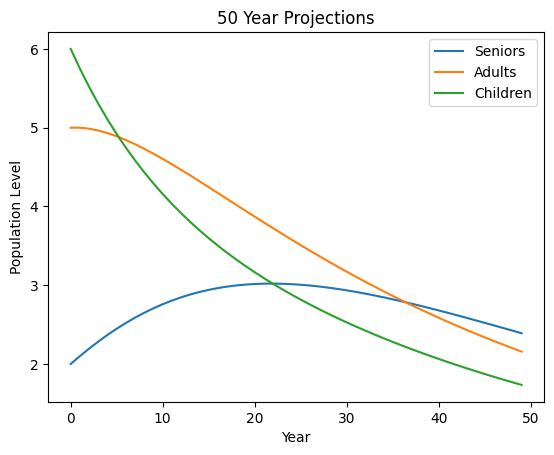

In [5]:
plots = plt.plot(projections.T)
plt.legend(plots, ["Seniors", "Adults", "Children"])
plt.title("50 Year Projections")
plt.xlabel("Year")
plt.ylabel("Population Level")
plt.show()

c) From the largest eigenvalue/eigenvector, what is the overall limiting population growth rate (e.g. 1.02 or .97 etc) and what is the limiting population distribution? Calculate the ratio of each computed total population to that of the preceding year and plot it in a separate plot along with the horizontal line representing the limiting population growth rate. In the same figure plot the fraction of the computed population in each group over time and compare with the with distribution predicted by the largest eigenvalue’s corresponding eigenvector.

In [6]:
A_eigenvalues = np.linalg.eig(A).eigenvalues
A_eigenvectors = np.linalg.eig(A).eigenvectors

print(A_eigenvalues)
print(A_eigenvectors)

[0.90166502 0.93685557 0.98147941]
[[-0.54894551 -0.94983762 -0.69918273]
 [ 0.66333178  0.31212689 -0.55024655]
 [-0.50857623 -0.01962923 -0.45647808]]


The largest eigenvalue is 0.98147941, so the total population is going to zero. We can calculate the limiting distribution from the corresponding eigenvector.

In [7]:
largest_eig_index = np.argmax(A_eigenvalues)
limiting_distribution = A_eigenvectors[:, largest_eig_index] / A_eigenvectors[:, largest_eig_index].sum()

limiting_distribution

array([0.40985973, 0.32255359, 0.26758668])

Spot check

In [8]:
(A @ limiting_distribution) / (A @ limiting_distribution).sum()

array([0.40985973, 0.32255359, 0.26758668])

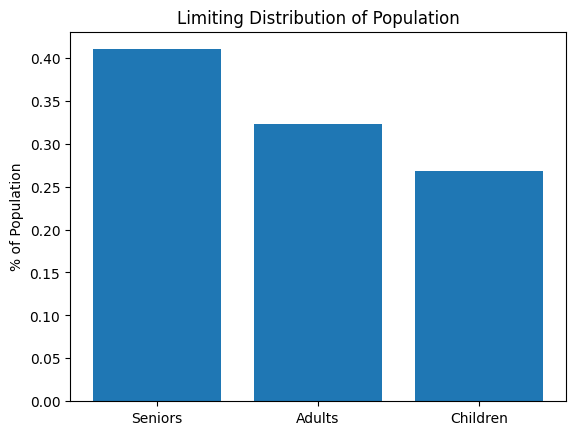

In [9]:
x = np.arange(len(limiting_distribution))
plt.bar(x, limiting_distribution)
plt.ylabel("% of Population")
plt.xticks(x, ["Seniors", "Adults", "Children"])
plt.title("Limiting Distribution of Population")
plt.show()

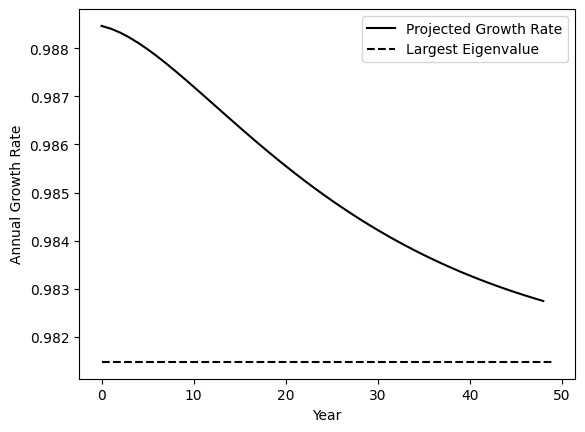

In [10]:
projected_total_population = projections.sum(axis=0)
projected_total_population_annual_growth = projected_total_population[1:] / projected_total_population[:-1]

plt.plot(projected_total_population_annual_growth, color="black", label="Projected Growth Rate")
plt.hlines(np.max(A_eigenvalues), 0, len(projected_total_population_annual_growth), color="black", linestyle="dashed", label="Largest Eigenvalue")
plt.legend()
plt.ylabel("Annual Growth Rate")
plt.xlabel("Year")
plt.show()

Note the scale of the y-axis. This is almost spot on.

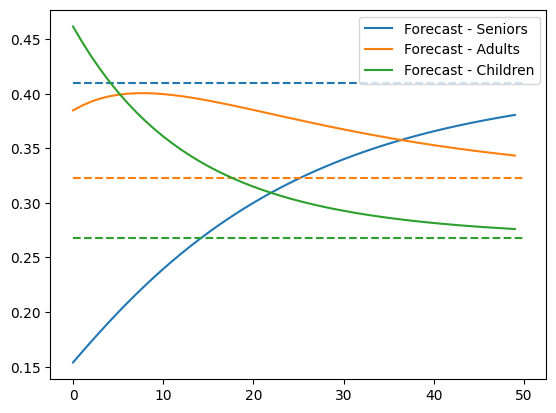

In [11]:
projected_proportions = projections / projected_total_population
eigenvector_proportions = A_eigenvectors[:, -1]/A_eigenvectors[:, -1].sum()

colors=["C0", "C1", "C2"]
labels=["Seniors", "Adults", "Children"]
for data, eq, c, label in zip(projected_proportions, eigenvector_proportions, colors, labels):
    plt.plot(np.arange(len(data)), data, c=c, label=f"Forecast - {label}")
    plt.hlines([eq], 0, 50, color=c, linestyles="dashed")

plt.legend()

So, the proportions seem to converge towards the predicted values from the eigenvector analysis.

d) The government is obviously concerned over the low reproduction rate facing them
for the next 50 years and decides to begin an incentive program to encourage more
babies being born to adults. What is the target adult reproduction rate that will stabilize
the population over time (overall population growth rate of 1)? Assume that the
program is immediately successful in achieving a stable growth rate. Given the same
initial vector $\begin{bmatrix} 2 \\ 5 \\ 6\end{bmatrix}$, calculate the limiting population vector (not just the
distribution but the actual populations of the subgroups) ? For this you will need the
three eigenvalues/eigenvectors and solve the initial value problem.

**Approach 1: Nonlinear Optimization**

Let $g$ be the adult reproduction rate. Let $A_g$ be the transition matrix when $g$ is the adult reproduction rate.

The population is going to be stable if all the eigenvalues fo $A_g$ are $\le 1$, and exactly one eigenvalue is 1. Let $\Lambda(A)$ be the eigenvalues of $A$. Then $f(g) = |1 - \max(\Lambda(A_g))|$. We want to find $g^*$ that minimizes $f(g)$. This is going to be some kind of polynomial thing, ergo smoothish, so it's won't be hard for a generic nonlinear optimizer.

In [12]:
# transition matrix as a function of adult reproduction rate
def A_g(g):
    M = A.copy()
    M[2, 1] = g # note that python arrays are 0-indexed
    return M

def f(g):
    l_max = np.max(np.linalg.eig(A_g(g)).eigenvalues)
    return abs(l_max - 1)

# using 0.03 as the initial guess, and bounding at 0 and 1, ~the physical limits
min_result = minimize(f, 0.03, bounds=[[0, 1]])
min_result

/var/folders/l_/zjyw1l0d37x3lbbq6x4vvs_00000gn/T/ipykernel_54255/868478647.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  M[2, 1] = g # note that python arrays are 0-indexed


  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 1.8115942079788283e-09
        x: [ 7.600e-02]
      nit: 6
      jac: [-2.220e-08]
     nfev: 60
     njev: 30
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In the output above, `x` is the optimal value of $g$, and `fun` is the value of the objective function at the optimal value. `fun` is a numerical zero, so this is saying that an adult reproduction rate of 7.6% will stabilize the population.


Did it work?

In [13]:
g_opt = min_result.x # optimal value of g
A_eq = A_g(g_opt) # a transition matrix with nonzero equilibrium

intervention_eigenvalues = np.linalg.eig(A_eq).eigenvalues
intervention_eigenvectors = np.linalg.eig(A_eq).eigenvectors

print(intervention_eigenvalues)
print(intervention_eigenvectors)

[0.87535899 0.94464102 1.        ]
[[-0.31155981 -0.99106916 -0.45584233]
 [ 0.58137851  0.1327781  -0.56980289]
 [-0.75161793  0.01232451 -0.68376344]]


/var/folders/l_/zjyw1l0d37x3lbbq6x4vvs_00000gn/T/ipykernel_54255/868478647.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  M[2, 1] = g # note that python arrays are 0-indexed


Yes, the eigenvalues are $[0.87535899, 0.94464102, 1.        ]$. The largest eigenvalue is 1, so the population is stable.

**Approach 2: Analytical Solution**

We can also solve for an equilibrium value of $g$ analytically.

$$
A_g = \begin{bmatrix}
    0.95 & 0.04 & 0 \\
    0 & 0.94 & 0.05 \\
    0.01 & g & 0.93
\end{bmatrix}
$$

Get the eigenvalue equation.

$$
A_g - \lambda I = \begin{bmatrix}
    0.95 - \lambda & 0.04 & 0 \\
    0 & 0.94 - \lambda & 0.05 \\
    0.01 & g & 0.93 - \lambda
\end{bmatrix}
$$

$$\det(A_g - \lambda I) = 0$$

We only care about the case where $\lambda = 1$. So, perform this substitution, then solve for $g$.

$$
A_g - I = \begin{bmatrix}
    0.95 - 1 & 0.04 & 0 \\
    0 & 0.94 - 1 & 0.05 \\
    0.01 & g & 0.93 - 1
\end{bmatrix}
$$

$$
A_g - I = \begin{bmatrix}
    -0.05 & 0.04 & 0 \\
    0 & -0.06 & 0.05 \\
    0.01 & g & -0.07
\end{bmatrix}
$$

$$\det(A_g - I) = 
(-0.05)((-0.06 * -0.07) - (0.05 * g))
- (0.04)((0*-0.07) - (0.05*0.01))
+ (0)(0*g - (0.01*-0.06))
$$

$$\det(A_g - I) = 
(-0.05)((-0.06 * -0.07) - (0.05 * g))
- (0.04)((0*-0.07) - (0.05*0.01))
+ (0)(0*g - (0.01*-0.06))
$$

$$\det(A_g - I) = 0.0025 g - 0.00019 = 0$$

$$g = 0.00019 / 0.0025 = 0.076$$

This is the same result as the numerical approach.

So, we need an adult reproduction rate of 7.6%. How do we interpret this? Every year, 4% become seniors. So, if we assume attrition rate is uniform with age among adults, this implies that people are "adults" for (1/0.04=) 25 years. If each adult has 7.6% of a child per year, this implies an adult fertility of (7.6%*25) = 1.9 total children per adult (not counting children the same people may have as seniors). This seems like a lot. I think current US fertility is about half that.

However, if adults have a 2% fatality rate per year, then only (1-2%*25=) 50% of adults survive to seniorhood, so this is a fairly brutal environment.

We plot the limiting distribution of the population proportions:

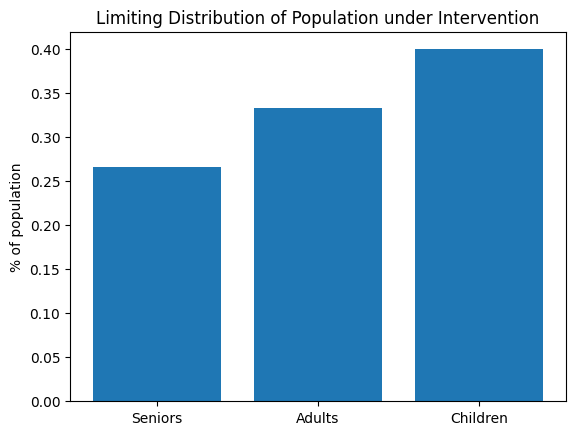

In [14]:
intervention_limiting_distribution = intervention_eigenvectors[:, 2] / intervention_eigenvectors[:, 2].sum()

x = np.arange(len(intervention_limiting_distribution))
plt.bar(x, intervention_limiting_distribution)
plt.xticks(x, ["Seniors", "Adults", "Children"])
plt.ylabel("% of population")
plt.title("Limiting Distribution of Population under Intervention")
plt.show()

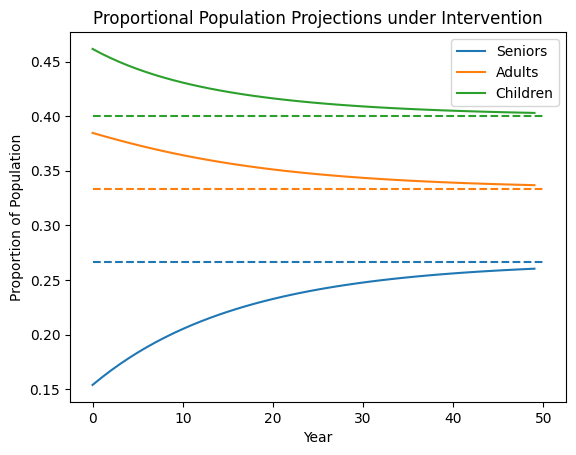

In [15]:
intervention_simulations = project(A_eq, 50)
intervention_simulated_proportions = intervention_simulations / intervention_simulations.sum(axis=0)

simulated_lines = plt.plot(intervention_simulated_proportions.T)
for i, level in enumerate(intervention_limiting_distribution):
    plt.hlines(level, 0, 50, color=f"C{i}", linestyle="dashed")

plt.title("Proportional Population Projections under Intervention")
plt.legend(simulated_lines, ["Seniors", "Adults", "Children"])
plt.xlabel("Year")
plt.ylabel("Proportion of Population")
plt.show()

So, when we simulate the population proportions going forward with this transition matrix, they seem to converge to the equilibrium distribution.

We can now solve for the projected absolute population levels under the intervention.

In [16]:
intervention_simulations[:, -1]

array([3.76468363, 4.87090725, 5.82779192])

In [17]:
eigenvalues_eq = np.linalg.eig(A_eq).eigenvalues
eigenvectors_eq = np.linalg.eig(A_eq).eigenvectors

print(eigenvalues_eq)
print(eigenvectors_eq)

[0.87535899 0.94464102 1.        ]
[[-0.31155981 -0.99106916 -0.45584233]
 [ 0.58137851  0.1327781  -0.56980289]
 [-0.75161793  0.01232451 -0.68376344]]


In [18]:
c = np.linalg.solve(eigenvectors_eq, p_0)
c

array([-0.19918644,  1.96365371, -8.52061762])

The third eigenvalue is 1, so the equilibrium is the third eigenvector times the third constant.

In [19]:
eq = eigenvectors_eq[:, 2] * c[2]
eq

array([3.88405815, 4.85507251, 5.82608684])

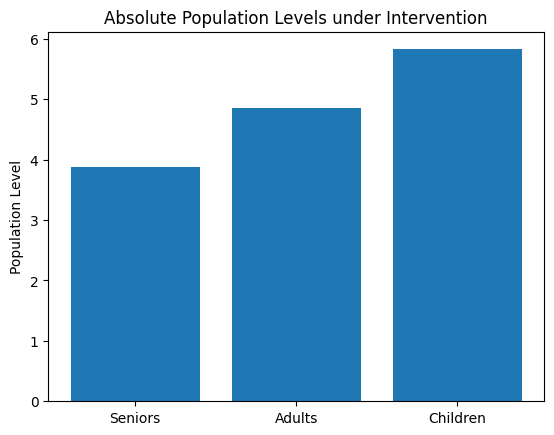

In [20]:
plt.bar([1, 2, 3], eq)
plt.title("Absolute Population Levels under Intervention")
plt.xticks([1, 2, 3], ["Seniors", "Adults", "Children"])
plt.ylabel("Population Level")
plt.show()

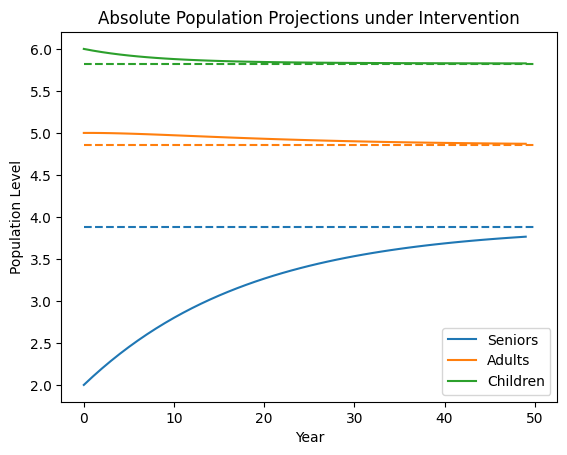

In [21]:
plt.plot(intervention_simulations.T)

for i, level in enumerate(eq):
    plt.hlines(level, 0, 50, color=f"C{i}", linestyle="dashed")

plt.title("Absolute Population Projections under Intervention")
plt.legend(["Seniors", "Adults", "Children"])
plt.xlabel("Year")
plt.ylabel("Population Level")
plt.show()

2) The gamma distribution has probability density $\gamma_k(t) = {1 \over (k - 1)!}t^{k - 1}e^{-t}$ for $k = 1 ,2, ...$ and is the distribution of the sum of $k$ independent standard exponential distributions of density $p(t) = e^{−t}$. Simulate the gamma distribution for $k = 10$ using 10,000 random samples. Recall that a single exponential random variable is simulated by $t = −\log u$ so a single random sample of our geometric distribution would be $\sum_{i = 1}^k - \log u_i$.

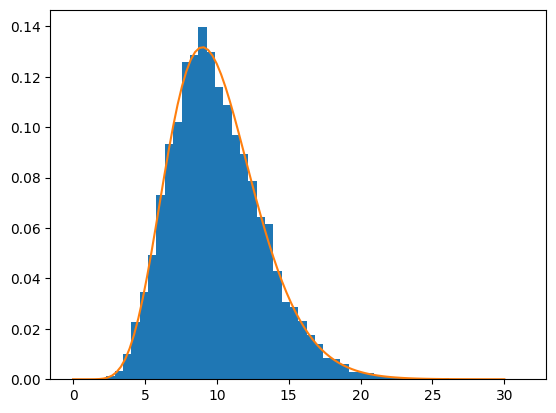

In [22]:
k = 10
n = 10000

U = np.random.random([n, k])
G = (-np.log(U)).sum(axis=1)
plt.hist(G, bins=50, density=True)

x = np.linspace(0, 30, 100)
gamma_analytical = stats.gamma(a=10, scale=1).pdf(x)
plt.plot(x, gamma_analytical)

plt.show()

This looks correct.